In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pygam import LinearGAM, s
from sklearn.metrics import r2_score
import numpy as np
from scipy.stats import sem
import math
import openpyxl

C:\Users\huynhdam\AppData\Local\anaconda3\envs\my_env_python_3.10\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def calculate_sem_excluding_nan(data):
    """
    Calculate the Standard Error of the Mean (SEM), excluding NaN values.

    Args:
    - data: NumPy array or pandas DataFrame with shape (n_samples, n_features).

    Returns:
    - sem_values: NumPy array containing the SEM values for each column.
    """
    if isinstance(data, pd.DataFrame):
       
        data = data.values
    
    
    non_nan_counts = np.sum(~np.isnan(data), axis=0)
    
    
    std_devs = np.nanstd(data, axis=0, ddof=0)
    
 
    sem_values = std_devs / np.sqrt(non_nan_counts)
    
    return sem_values


In [12]:




np.random.seed(100)  


def permutation_test(gam, X, y, num_permutations=1000):
    np.random.seed(100) 
    actual_r2 = r2_score(y, gam.predict(X))
    null_r2 = []
    
    for _ in range(num_permutations):
        y_permuted = np.random.permutation(y)
        gam.fit(X, y_permuted)
        null_r2.append(r2_score(y_permuted, gam.predict(X)))

    null_r2 = np.array(null_r2)  # Convert list to numpy array

    p_value = (np.sum(null_r2 >= actual_r2) + 1) / (num_permutations + 1)
    
    return p_value

    

def GAM_graph_knot_choice(data, num, num_knots=10, save_path=None):
    np.random.seed(100) 
    
  
    month_names = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 
        5: 'May', 6: 'June', 7: 'July', 8: 'August', 
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }

    means = np.nanmean(data, axis=0)  
    

    valid_indices = ~np.isnan(means)
    means_for_plotting = np.where(np.isnan(means), 0, means)
    
    std_devs = calculate_sem_excluding_nan(data)  
    
    std_devs_for_plotting = np.where(np.isnan(std_devs), 0, std_devs)  
    
    
    months = np.arange(1, 13)
    valid_months = months[valid_indices]
    

    plt.style.use('seaborn-v0_8-colorblind')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.errorbar(months, means_for_plotting, yerr=std_devs, fmt='o', color='darkblue', ecolor='lightblue', elinewidth=2, capsize=5)

 
    gam = LinearGAM(s(0, n_splines=num_knots)).fit(months[valid_indices].reshape(-1, 1), means[valid_indices])
        

    XX = np.linspace(1, 12, 100)
    smooth_means = gam.predict(XX.reshape(-1, 1)) 

    ax.plot(XX, smooth_means, label='_Hidden Label') 

  
    predictions = gam.predict(months[valid_indices].reshape(-1, 1))
    fitness_score = r2_score(means[valid_indices], predictions)


    p_value = permutation_test(gam, months[valid_indices], means[valid_indices])


    proposed_upper_ylim = max(means_for_plotting) + max(std_devs_for_plotting) * 1.5


    min_upper_ylim = 20



    actual_upper_ylim = max(proposed_upper_ylim, min_upper_ylim)


    actual_upper_ylim = math.ceil(actual_upper_ylim / 5) * 5

    ax.text(0.05, 0.95, f'Fitness Score (R-squared): {fitness_score:.3f}\nP-value: {p_value:.3f}',
    horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, 
     fontsize=20, bbox=dict(facecolor='white', alpha=0.8))
    
 
    ax.yaxis.set_major_locator(MultipleLocator(5))

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Litter in', fontsize=20)
    ax.set_ylabel('% offspring in month',fontsize=20)
    ax.set_title(month_names[num], fontsize=25)
    ax.set_xticks(months)
    ax.tick_params(axis='both', which='major', labelsize=16)  # Increase font size of major ticks
    ax.tick_params(axis='both', which='minor', labelsize=14)  # Increase font size of minor ticks
    ax.set_xlim(0.5, 12.5)

    ax.set_ylim(0, actual_upper_ylim)
    

    if save_path: 
        plt.savefig(save_path)
    plt.show() 




In [13]:
def GAM_graph_knot_choice_score(data, num_knots=10):
    np.random.seed(100)
    
    means = np.nanmean(data, axis=0)

   
    means = means.copy()

   
    valid_indices = ~np.isnan(means)
    
   
    if np.any(valid_indices):
        valid_means = means[valid_indices]
        valid_months = np.arange(1, 13)[valid_indices]

    
        gam = LinearGAM(s(0, n_splines=num_knots)).fit(valid_months.reshape(-1, 1), valid_means)

   
        predictions = gam.predict(valid_months.reshape(-1, 1))

       
        fitness_score = r2_score(valid_means, predictions)

       
        p_value = permutation_test(gam, valid_months, valid_means)
    else:
       
        fitness_score, p_value = np.nan, np.nan

    return fitness_score, p_value


In [14]:

np.random.seed(100) 



def process_data(data, species_name, data_type='Dam'):
    np.random.seed(100) 
    all_scores = []
    month_scores = []
    
   
    birth_month_columns = df.filter(like='BirthMonth').columns
    
    parent_column = birth_month_columns[0]
    
    for month in range(1, 13):
        values=[]
        
        values = data[data[parent_column] == month].iloc[:, 1:]  
      
        values = values.dropna(how='all')
 
        filename = f'./GAM/12 knots/{species_name} -{data_type} born in {month} (GAM 12 knots).png' 

        GAM_graph_knot_choice(values, month, num_knots=12, save_path=filename) 
         
            
   
        fitness_score, p_value = GAM_graph_knot_choice_score(values, num_knots=12)
        month_scores.append({'Month': month, 'Fitness Score': fitness_score, 'P-value': p_value})
        
    
   
    all_scores.extend(month_scores)
        
    
    scores_df = pd.DataFrame(all_scores)
    scores_df['Species'] = species_name  
    return scores_df



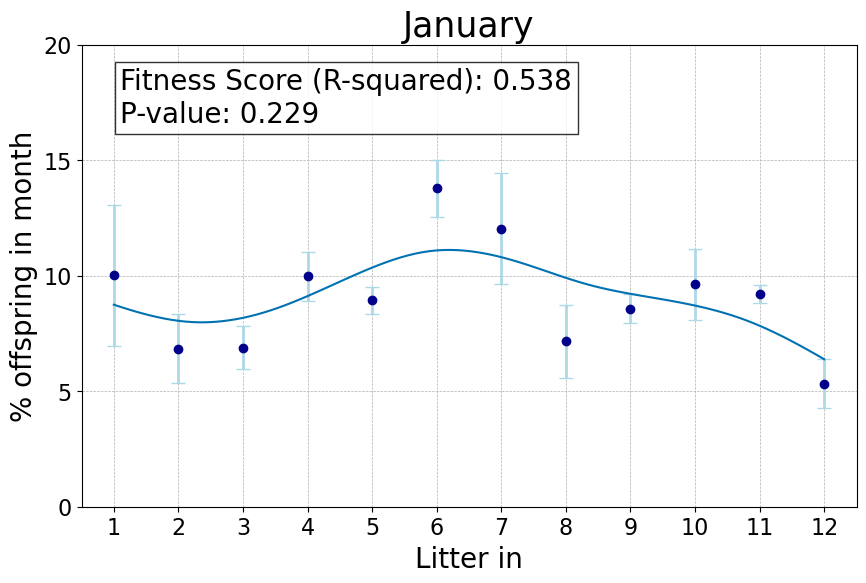

C:\Users\huynhdam\AppData\Local\Temp\ipykernel_10736\2389089463.py:32: RuntimeWarning: Mean of empty slice
  means = np.nanmean(data, axis=0)
C:\Users\huynhdam\AppData\Local\anaconda3\envs\my_env_python_3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


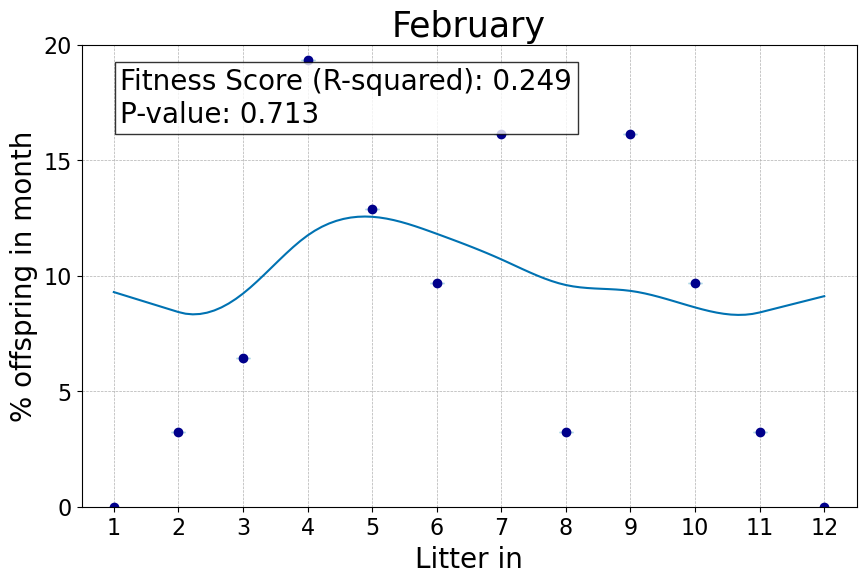

C:\Users\huynhdam\AppData\Local\Temp\ipykernel_10736\157786713.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(data, axis=0)


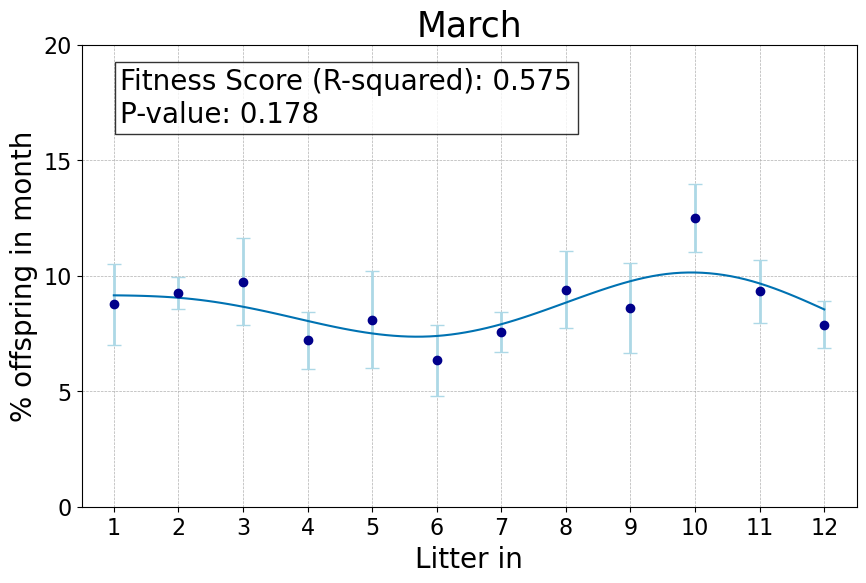

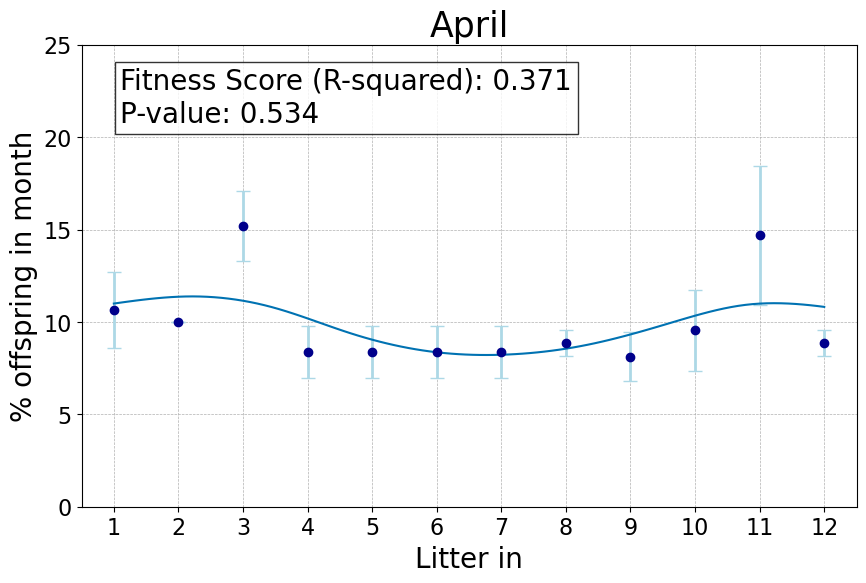

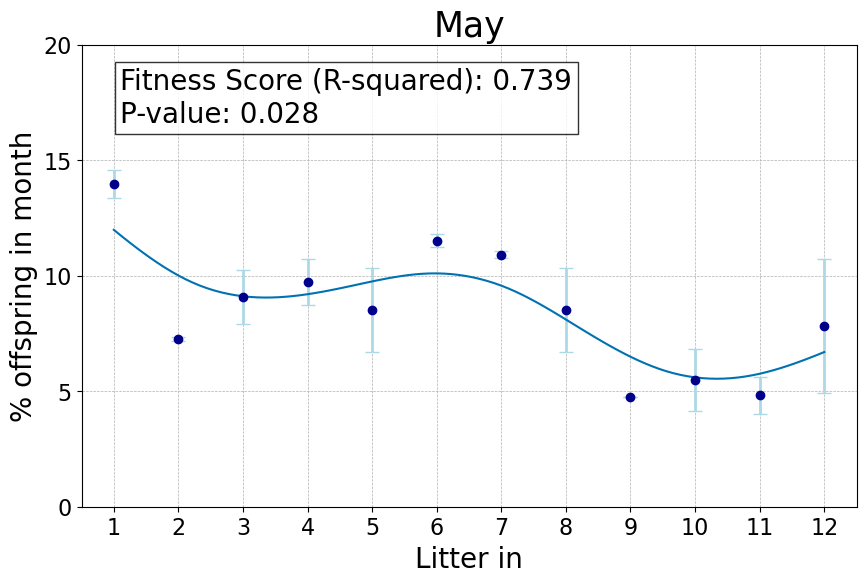

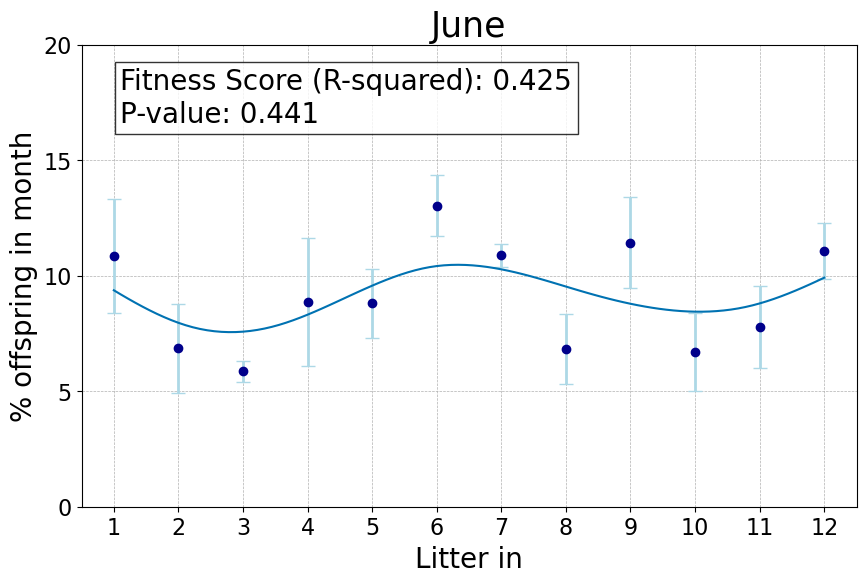

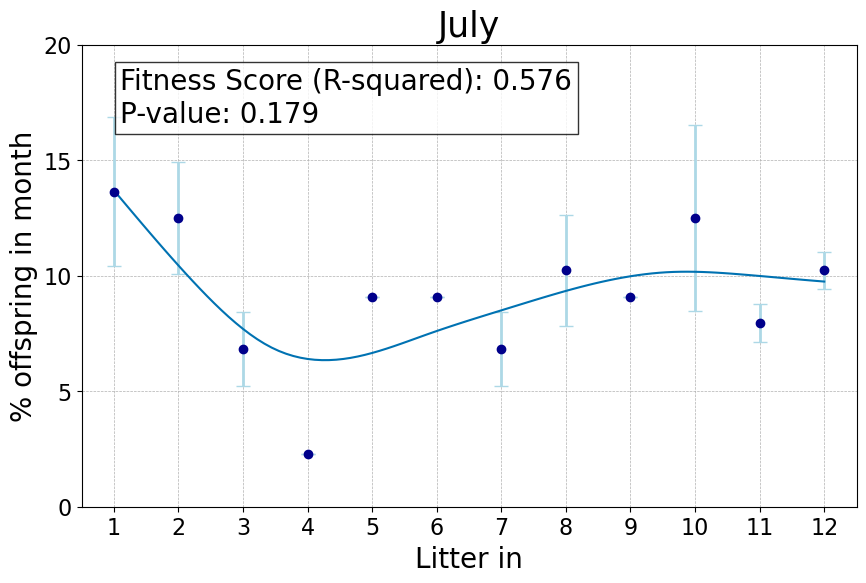

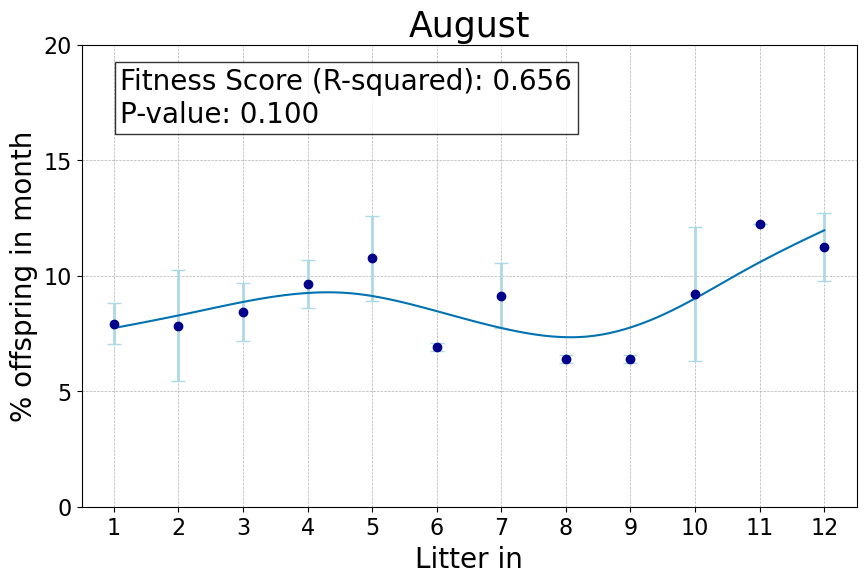

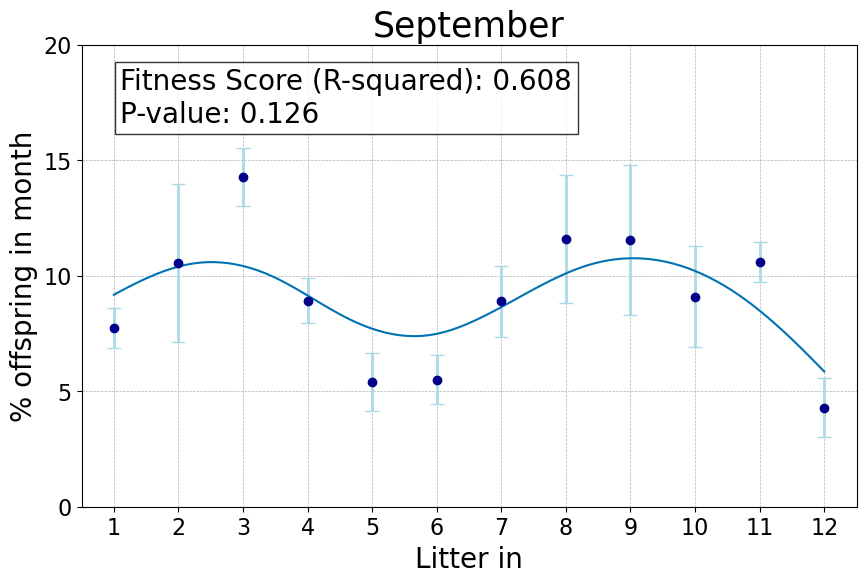

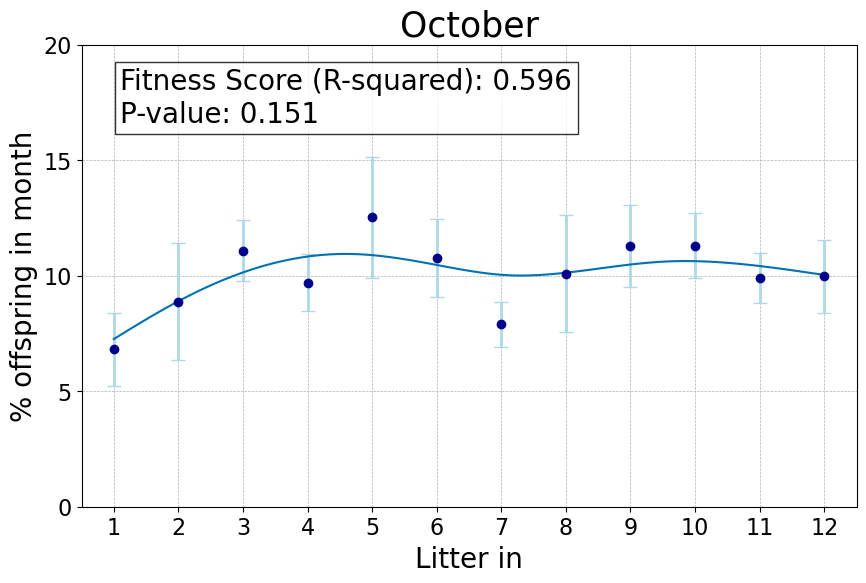

C:\Users\huynhdam\AppData\Local\Temp\ipykernel_10736\2389089463.py:32: RuntimeWarning: Mean of empty slice
  means = np.nanmean(data, axis=0)
C:\Users\huynhdam\AppData\Local\anaconda3\envs\my_env_python_3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


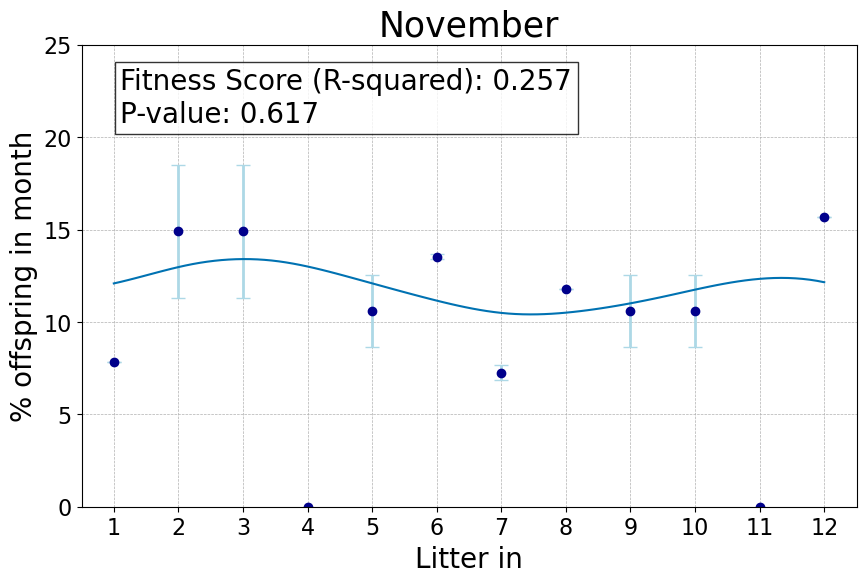

C:\Users\huynhdam\AppData\Local\Temp\ipykernel_10736\157786713.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(data, axis=0)


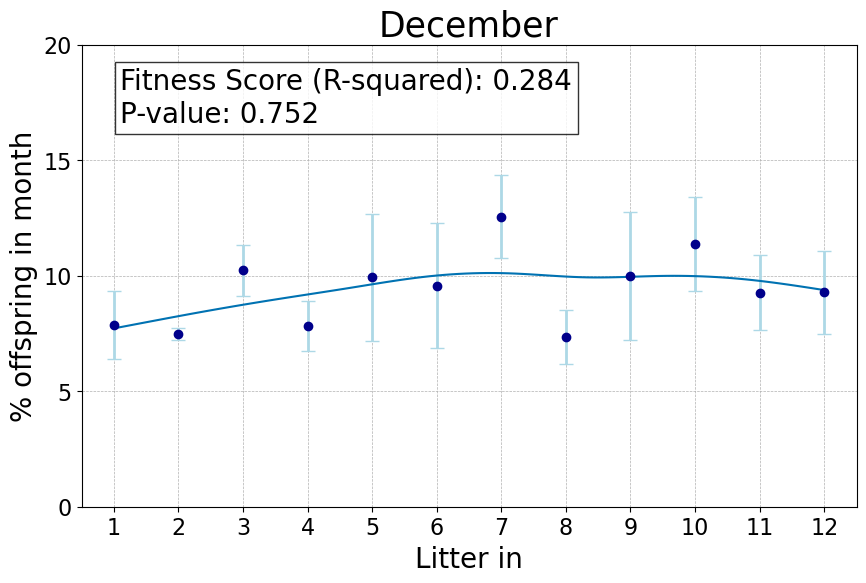

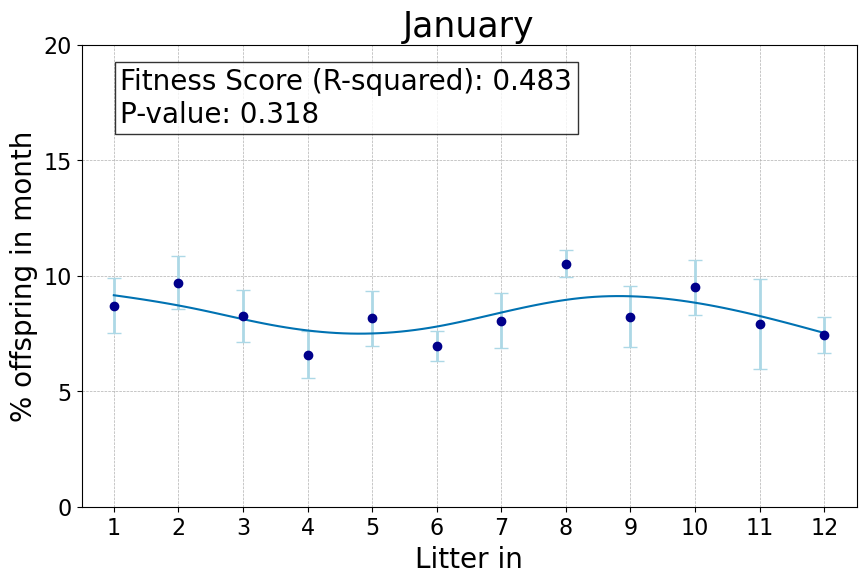

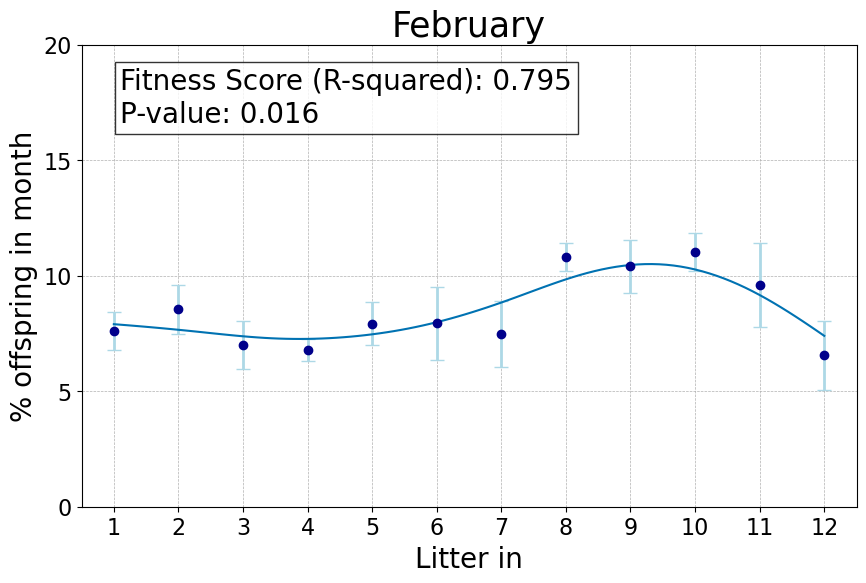

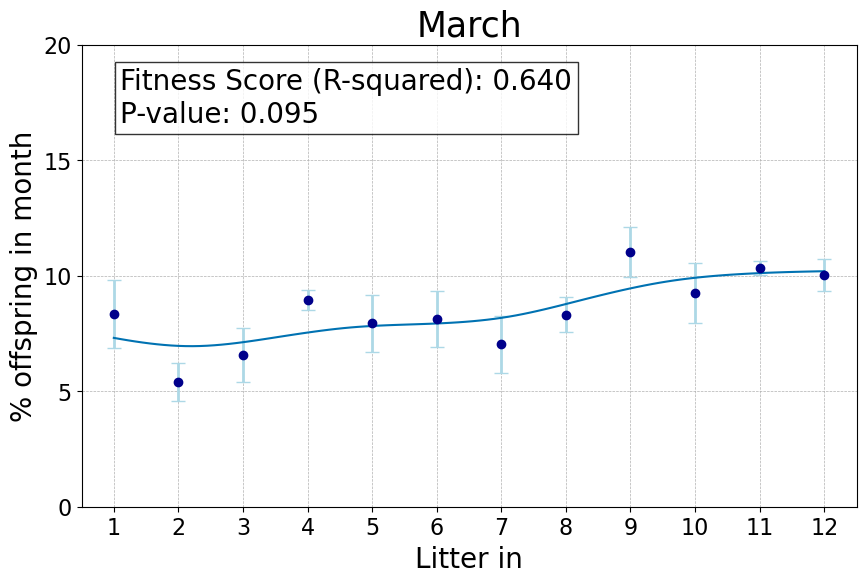

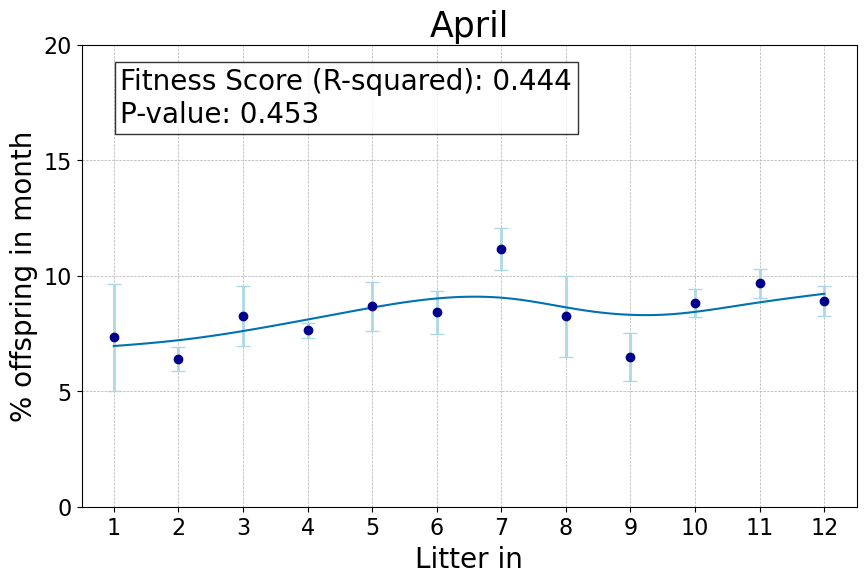

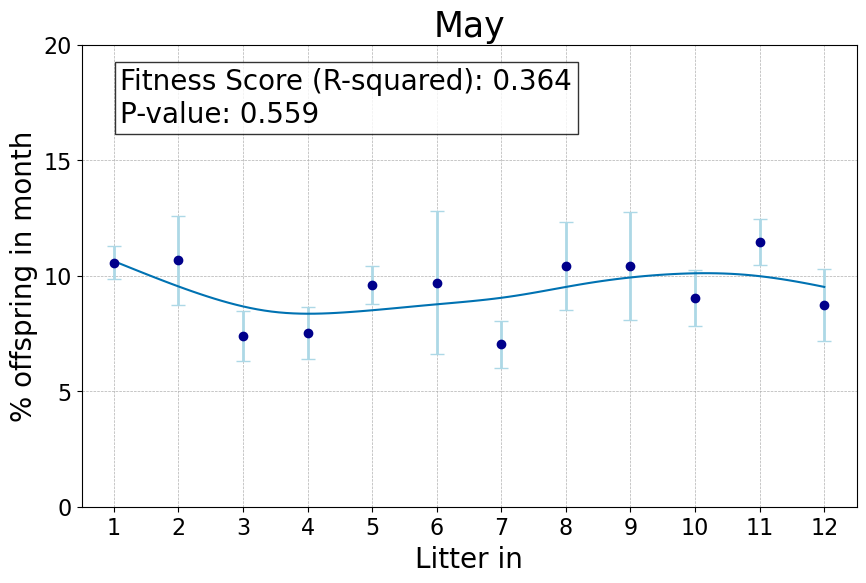

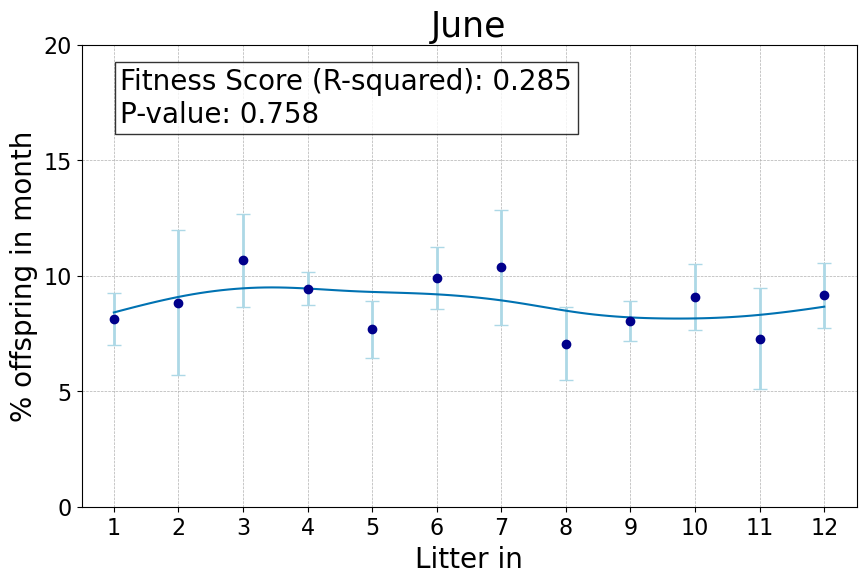

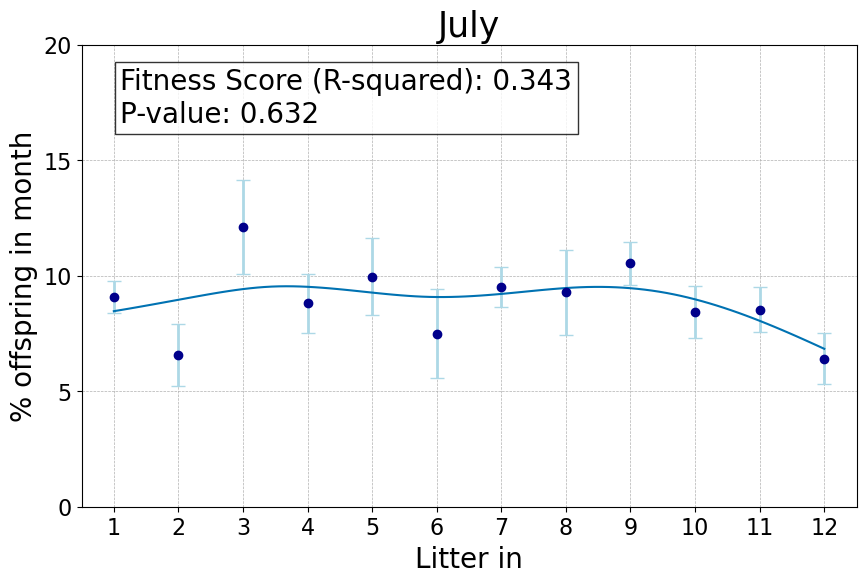

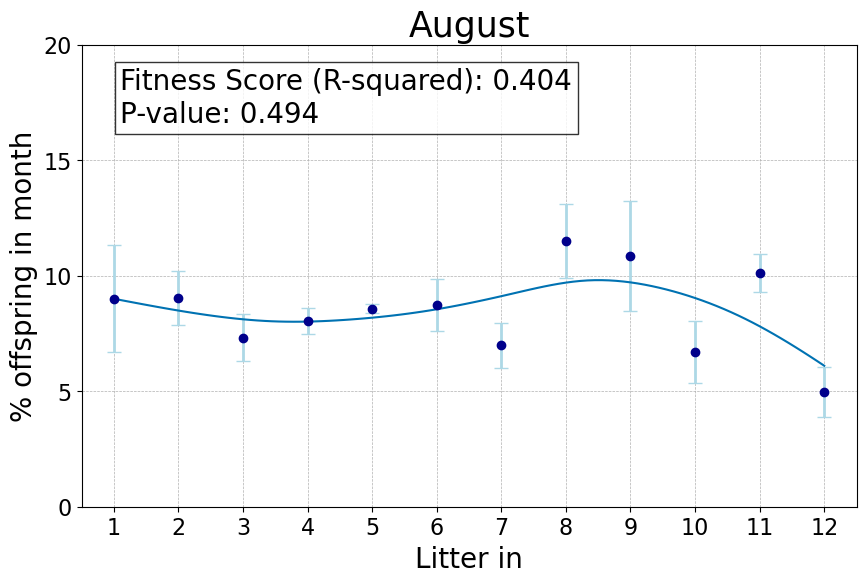

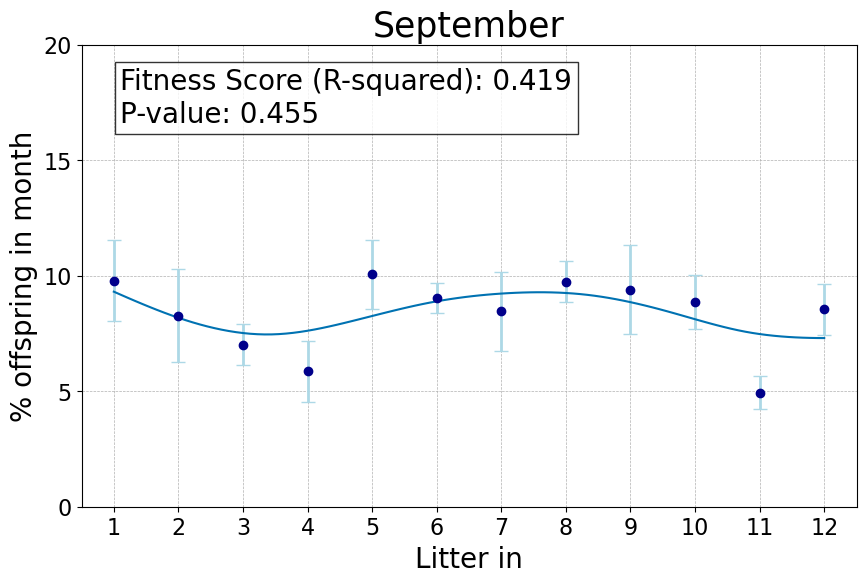

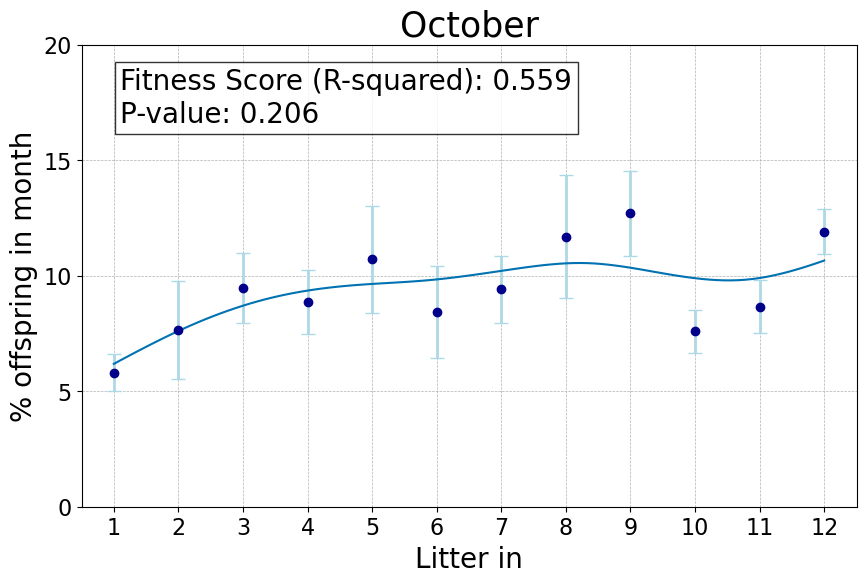

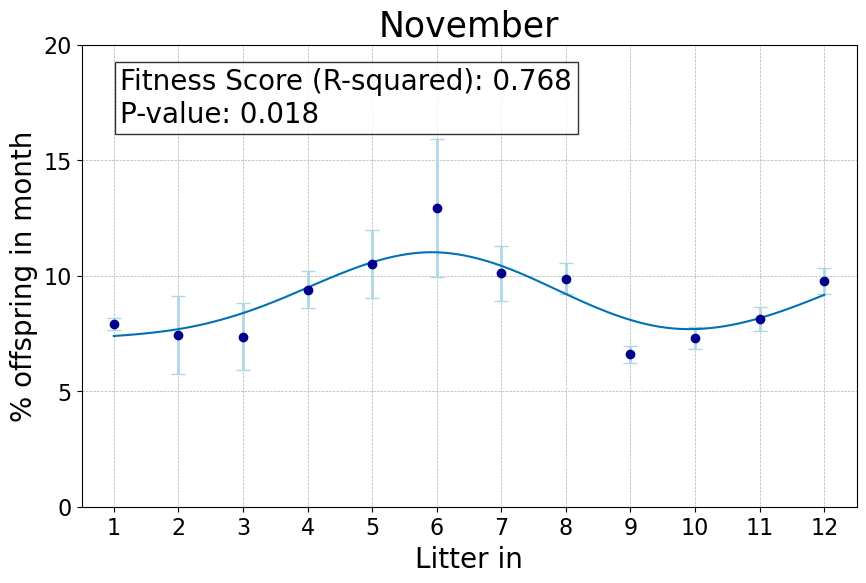

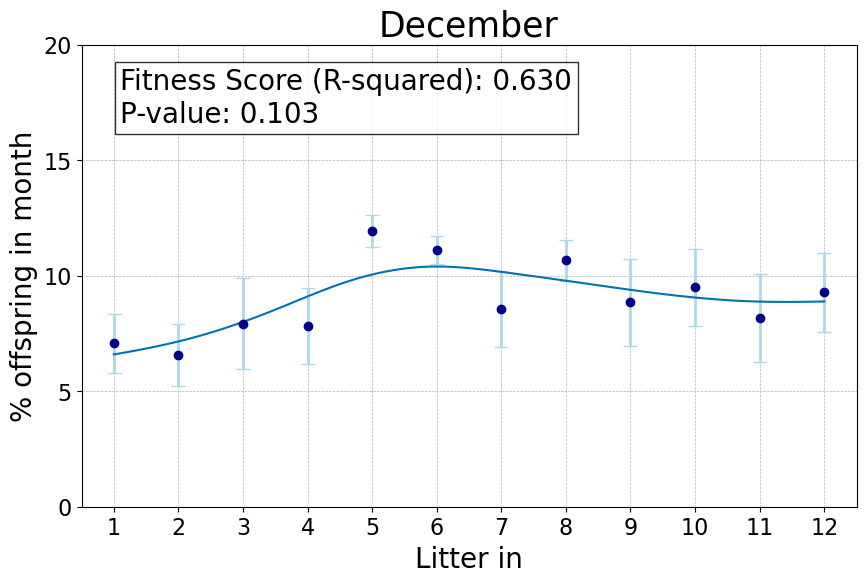

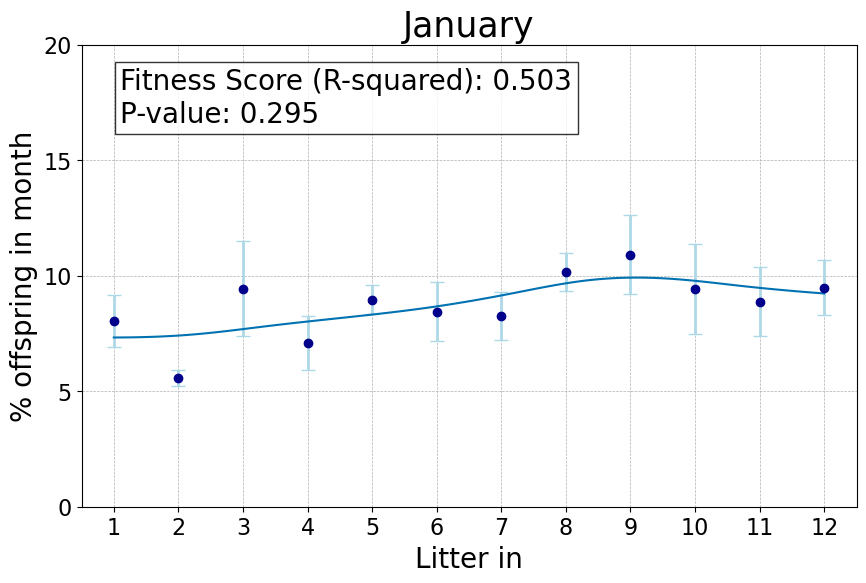

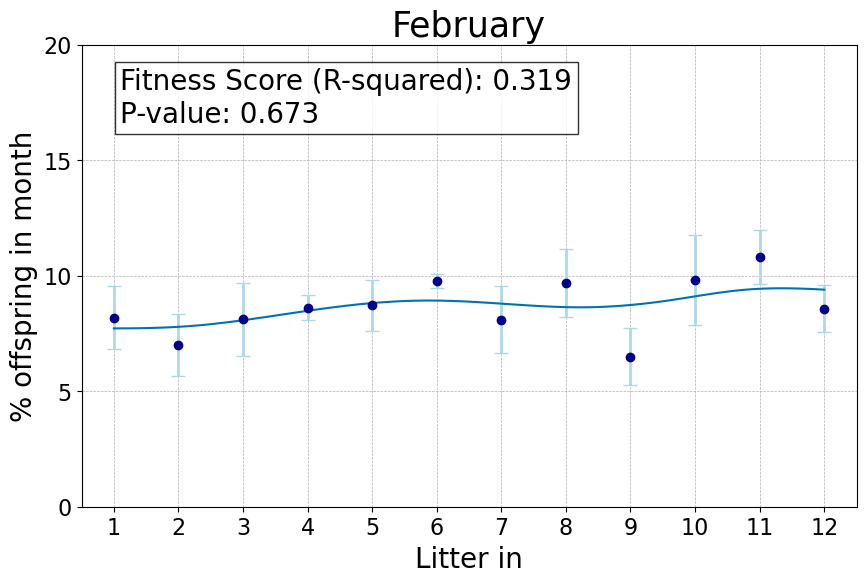

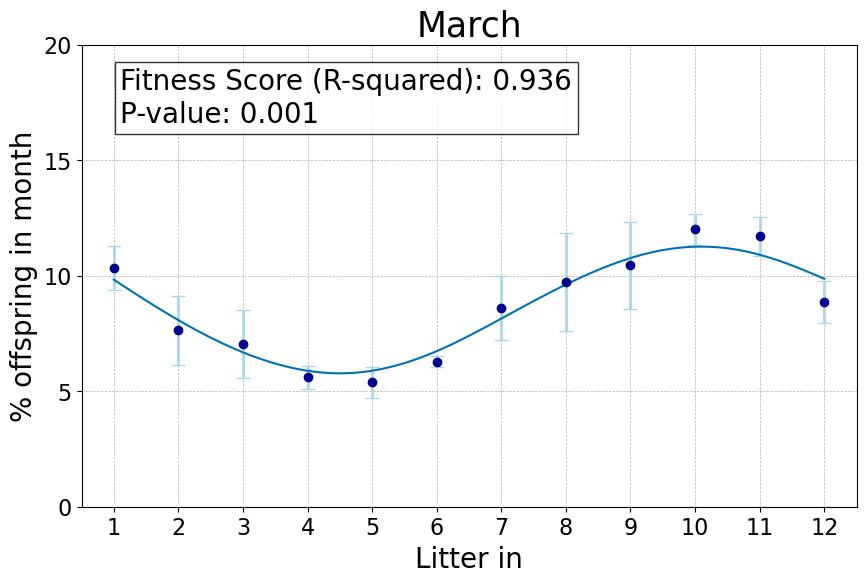

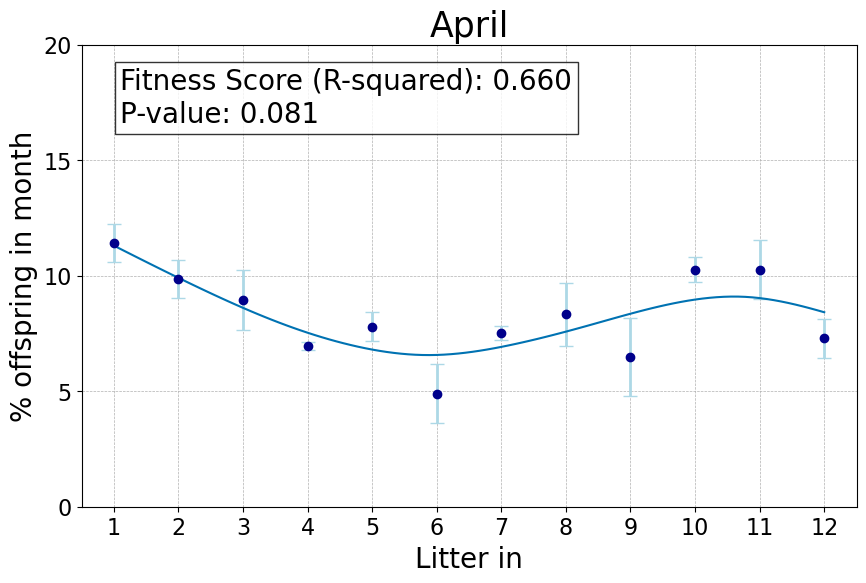

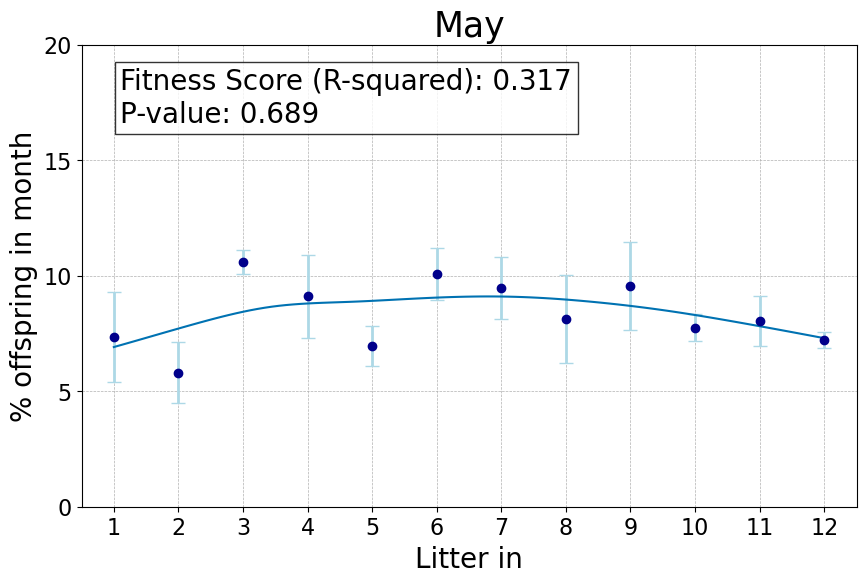

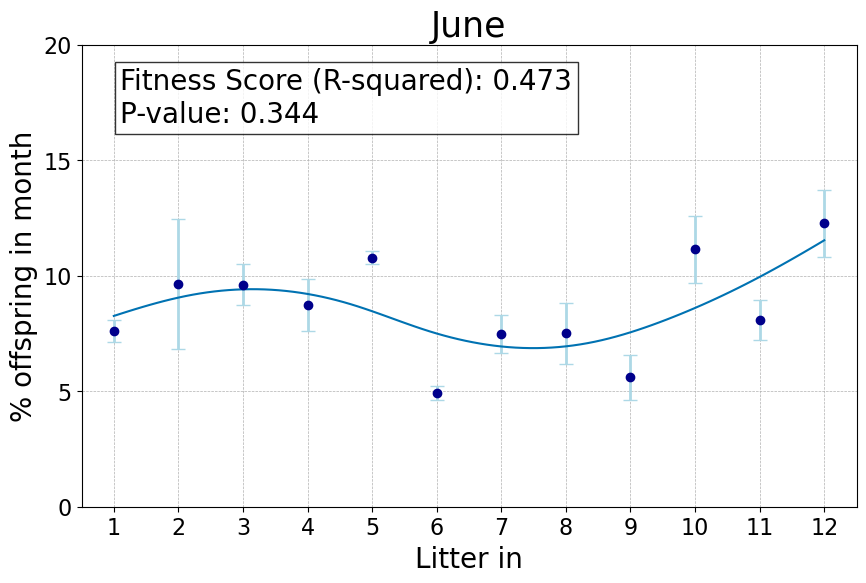

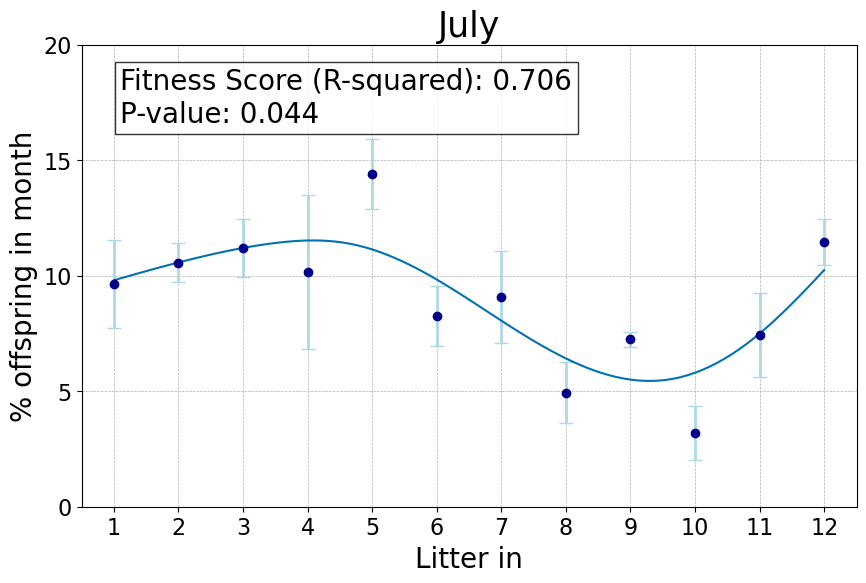

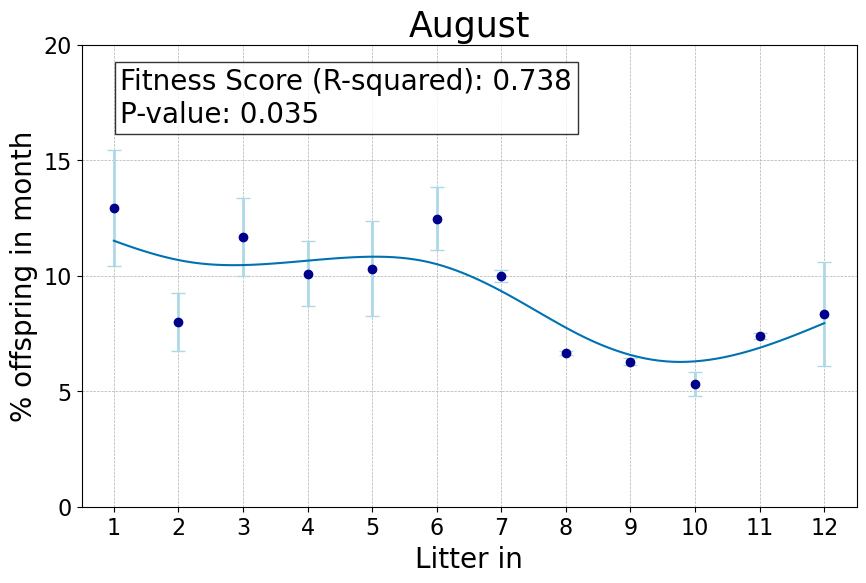

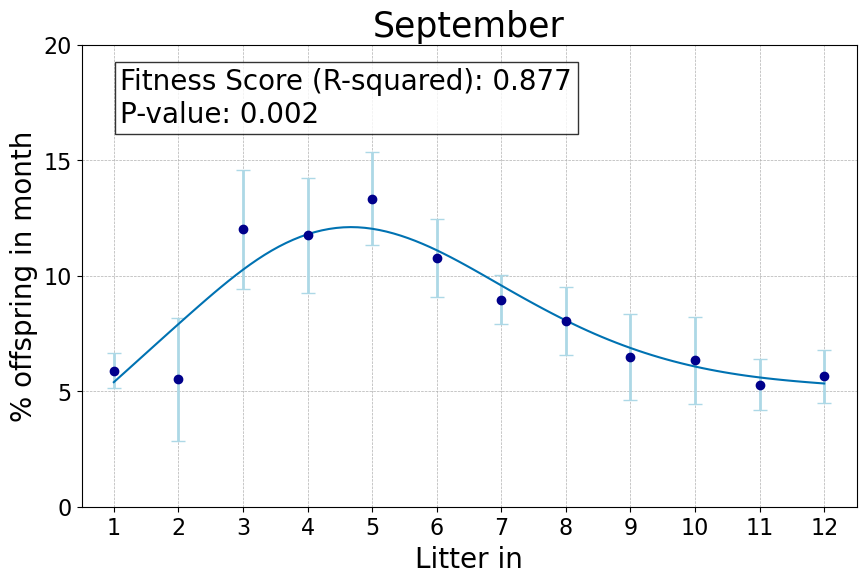

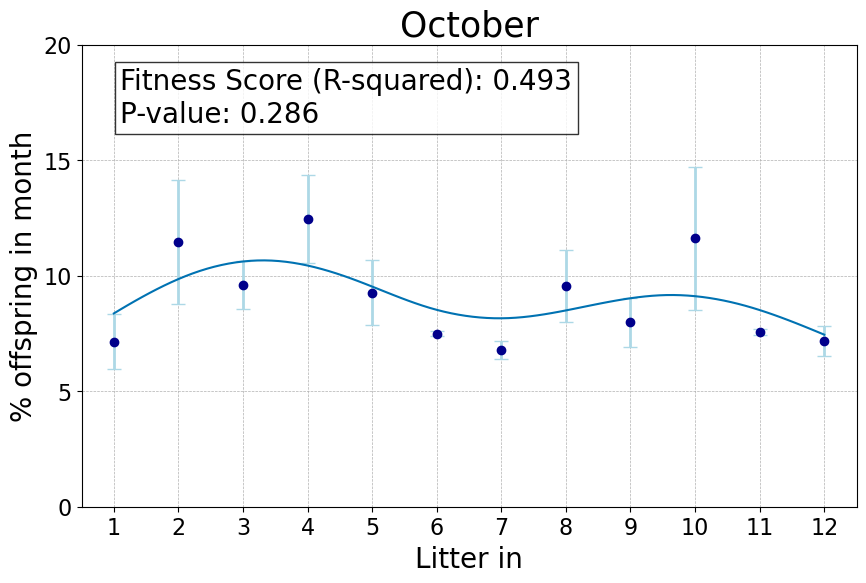

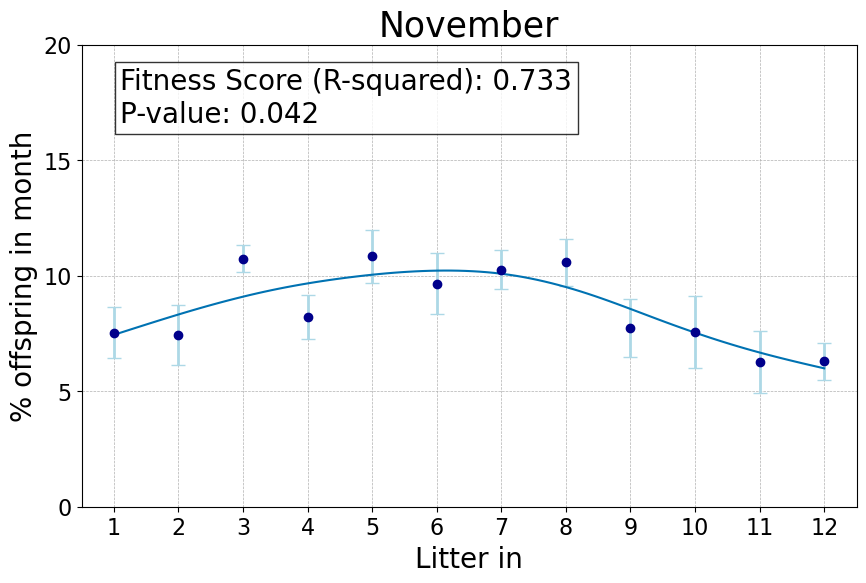

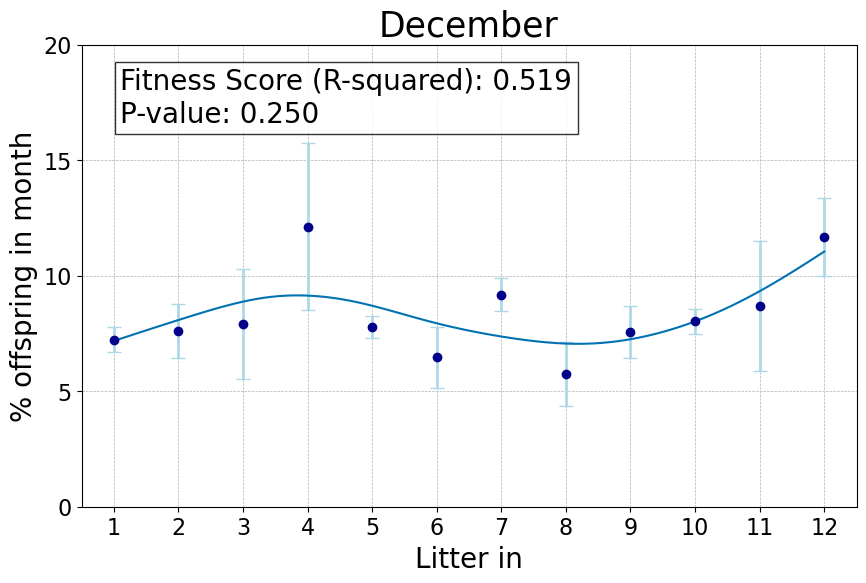

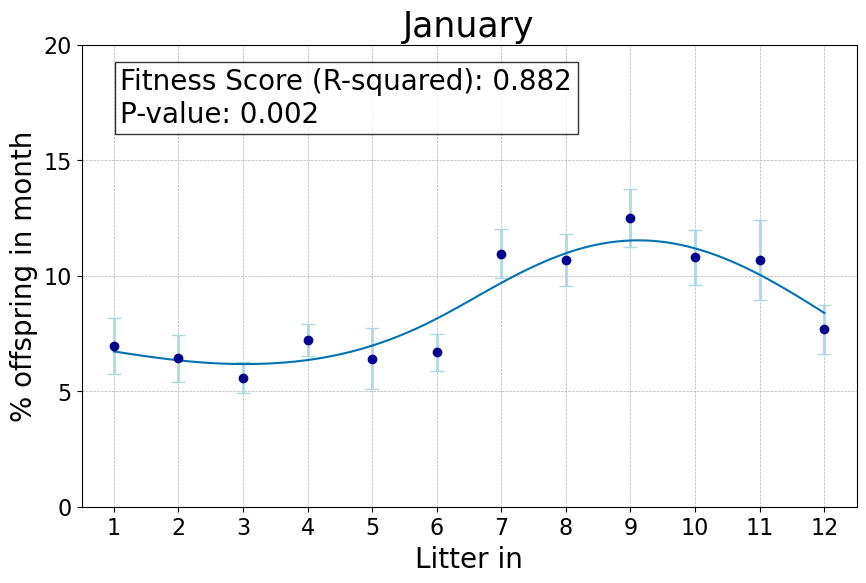

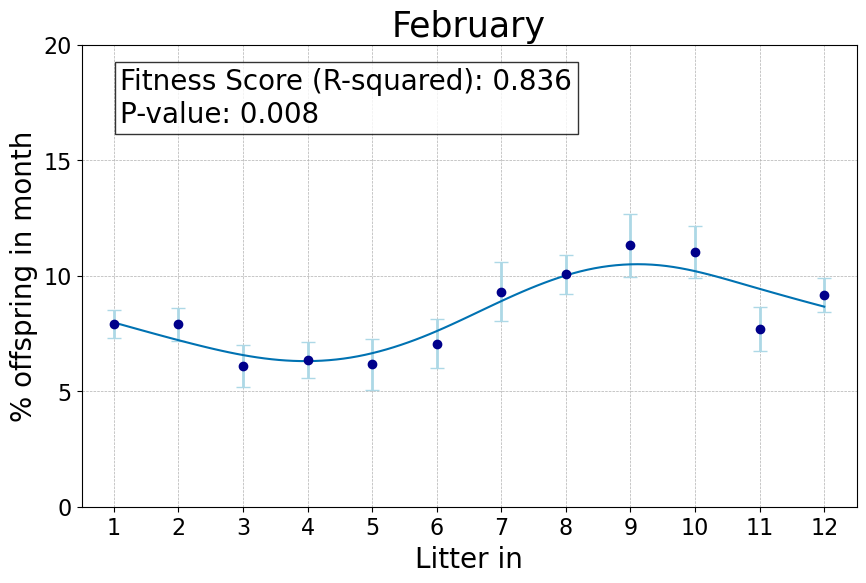

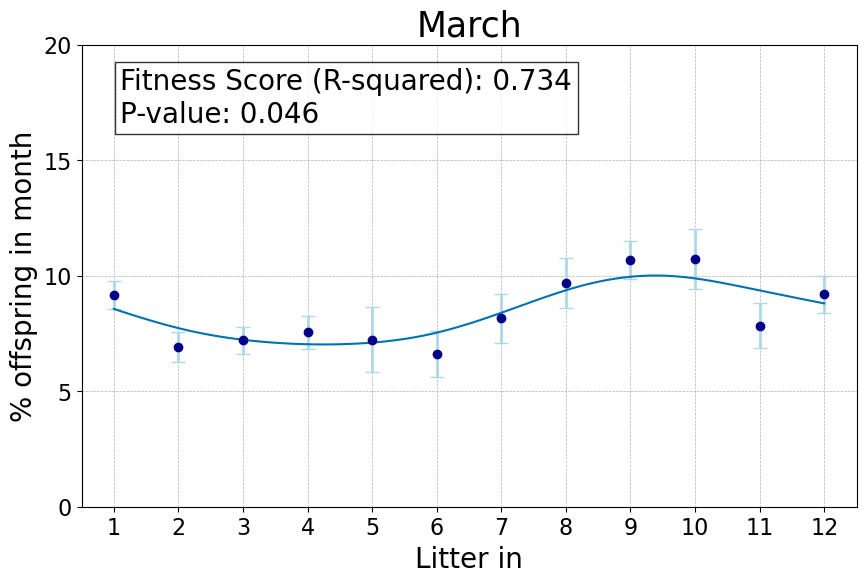

In [ ]:

species_list = ['EP', 'IS','SM2', 'BW', 'LL', 'PO'] 


Dam_Sire =['Dam','Sire']


for parent in Dam_Sire:
    combined_scores_df = pd.DataFrame()
    for species in species_list:
        
        file_path= f'./percentage offspring/{species}-{parent}-percentage of offspring by parent birthmonth.xlsx'
        
        df= pd.read_excel(file_path)
        df = df.iloc[:,:-1]
        
        species_scores_df = process_data(df, species, parent)
        
    
        combined_scores_df = pd.concat([combined_scores_df, species_scores_df], ignore_index=True)

        combined_scores_df.to_excel(f'./GAM/12 knots/{parent} -GAM (12 knots)- R-score and p-value -all species.xlsx', index=False, engine='openpyxl')

